ECML-PKDD 2020 Hands-on Tutorial

*What and How of Machine Learning Transparency*:  
Building Bespoke Explainability Tools with Interoperable Algorithmic Components

<https://events.fat-forensics.org/2020_ecml-pkdd/>

Authors: Kacper Sokol <k.sokol@bristol.ac.uk> and
         Alex Hepburn <ah13558@bristol.ac.uk>  
Licence:
[![Text Licence](https://img.shields.io/badge/licence--text-CC%20BY--NC--SA%204.0-red)](https://github.com/fat-forensics/Surrogates-Tutorial/blob/master/LICENCE)
[![Code Licence](https://img.shields.io/badge/licence--code-new%20BSD-red)](https://github.com/fat-forensics/Surrogates-Tutorial/blob/master/LICENCE-code)

---

---

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/Surrogates-Tutorial/blob/master/notebooks/3-data-sampling.ipynb)
[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/Surrogates-Tutorial/master?filepath=notebooks%2F3-data-sampling.ipynb)

First, we need to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
LIBRARY_URL = ('https://raw.githubusercontent.com/fat-forensics/'
               'Surrogates-Tutorial/master/notebooks/fatf_ecml.py')

try:
    import google.colab
    !wget $LIBRARY_URL -O fatf_ecml.py
except ImportError:
    pass

import fatf_ecml

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

%matplotlib inline

In [3]:
fatf_ecml.initialise_colab()

Not in Colab; nothing to do.


In [4]:
import fatf

In [5]:
import fatf.utils.data.augmentation as fatf_augmentation

22-Sep-08 12:49:10 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [6]:
import fatf.utils.data.discretisation as fatf_discretisation

# Data Sampling #
This notebook goes over a selection of data sampling methods and investigates
their behaviour with respect to the produced data.
To this end, we use implementations included in the
[`fatf.utils.data.augmentation`](https://fat-forensics.org/api.html#module-fatf.utils.data.augmentation)
module.
In particular, we will look at four different sampling methods for tabular data:

* [Normal Sampling](https://fat-forensics.org/generated/fatf.utils.data.augmentation.NormalSampling.html);
* [Truncated Normal Sampling](https://fat-forensics.org/generated/fatf.utils.data.augmentation.TruncatedNormalSampling.html);
* [Mixup](https://fat-forensics.org/generated/fatf.utils.data.augmentation.Mixup.html); and
* [Normal Class Discovery](https://fat-forensics.org/generated/fatf.utils.data.augmentation.NormalClassDiscovery.html).

These four approaches are implemented in FAT Forensics and are ready for you
to use out of the box.
Nonetheless, writing your own sampler is relatively easy.
You can use the abstract `fatf.data.utils.augmentation.Augmentation`
class as the foundation of your own method.
It implements a collection of helper methods and in most of the cases writing
your own `__init__` and `sample` methods suffices.

## Toy Example -- Two Moons ##
Let's start with the Two Moons data set -- it is two-dimensional,
which allows us to visualise the behaviour of each sampler and more easily
convey the idea behind them.

### Loading the Data ###
We start by loading the data.

In [7]:
moons_X, moons_X_test, moons_y, moons_y_test = fatf_ecml.generate_2d_moons(
    random_seed=42)

22-Sep-08 12:49:11 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:49:11 fatf         INFO     Seeding RNGs with 42.


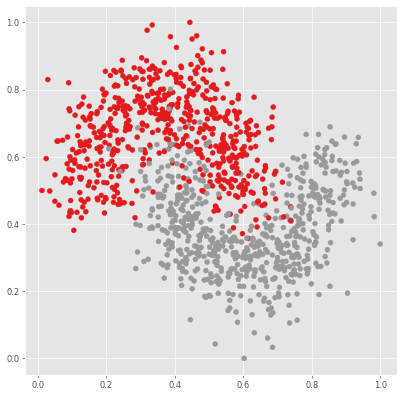

In [8]:
# Plot data
plt.figure(figsize=(8, 8), dpi=60)
plt.scatter(moons_X[:, 0], moons_X[:, 1], cmap=plt.cm.Set1, c=moons_y)

### Loading the Black-Box Models ###
Next, we load our *crisp* and *probabilistic* black boxes.

In [9]:
clf_moons_proba = fatf_ecml.get_random_forest(
    moons_X, moons_y, random_seed=42)

22-Sep-08 12:49:14 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:49:14 fatf         INFO     Seeding RNGs with 42.


In [10]:
clf_moons_crisp = fatf_ecml.get_svc(
    moons_X, moons_y, random_seed=42)

22-Sep-08 12:49:15 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:49:15 fatf         INFO     Seeding RNGs with 42.


### Selecting an Instance to be Explained ###
Now, let's select three instances to be explained -- thus sampled around --
each one with different characteristics:

* the mean of the data set;
* a point close to a decision boundary; and
* an instance that is far from a decision boundary.

These three data points will help us to observe artefacts of our sampling
strategies.

In [11]:
# Data points chosen to be sampled around
moons_mean_point = np.mean(moons_X, axis=0)
moons_boundary_point = np.array([0.3, 0.7])
moons_far_point = np.array([0.7, 0.2])

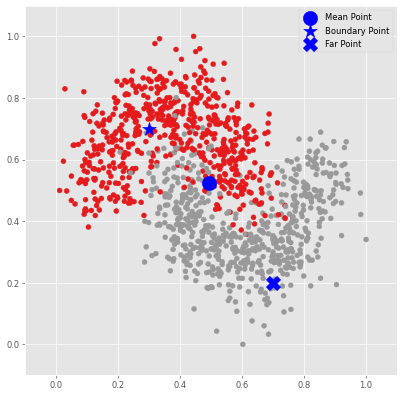

In [12]:
# Plot the points we are going to sample around
plt.figure(figsize=(8, 8), dpi=60)

plt.scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y)

plt.scatter(
    moons_mean_point[0], moons_mean_point[1],
    marker='o', c='b', s=300, label='Mean Point')

plt.scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=300, label='Boundary Point')

plt.scatter(
    moons_far_point[0], moons_far_point[1],
    marker='X', c='b', s=300, label='Far Point')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()

### Sampling ###
Let's move on to sampling.
We are going to sample 150 data points around each instance.

In [13]:
moons_samples_number = 150

#### Normal Sampling ####
We will start with *Normal Sampling*, which is accessible via the
[fatf.data.utils.augmentation.NormalSampling](https://fat-forensics.org/generated/fatf.utils.data.augmentation.NormalSampling.html)
class.

This sampler uses normal distribution $\mathcal{N}(\mu, \sigma^2)$
separately for each individual feature.
$\sigma^2$ is the standard deviation of this feature calculated for the data
set used to initialise this sampler.
$\mu$ is either the mean value of this feature calculated for the data set used
to initialise this sampler or a user-specified instance.
This is controlled by calling the `sample` method of the Normal Sampler:
* if no argument is passed to the `sample` method, the mean of the
  class initialisation data is used, e.g., `normal_sampler.sample()`; and
* if an instance is passed to the `sample` method, this data point is
  used instead, e.g., `normal_sampler.sample(np.array([4, 2]))`.

> **Tip:**&nbsp;&nbsp;&nbsp;&nbsp;
  *Click on the URL behind the class name to open its API documentation,
  which contains a more in-depth description.*

In [14]:
moons_normal_sampler = fatf_augmentation.NormalSampling(
    moons_X_test)

We start with the *mean* instance.

In [15]:
moons_normal_sample_mean = moons_normal_sampler.sample(
        moons_mean_point,
        samples_number=moons_samples_number)

moons_normal_sample_mean_crisp = clf_moons_crisp.predict(
    moons_normal_sample_mean)

Next, we move on to the *boundary* data point.

In [16]:
moons_normal_sample_close = moons_normal_sampler.sample(
    moons_boundary_point,
    samples_number=moons_samples_number)

moons_normal_sample_close_crisp = clf_moons_crisp.predict(
    moons_normal_sample_close)

And we finish with the *far* data point.

In [17]:
moons_normal_sample_far = moons_normal_sampler.sample(
    moons_far_point,
    samples_number=moons_samples_number)

moons_normal_sample_far_crisp = clf_moons_crisp.predict(
    moons_normal_sample_far)

Now, let's visualise these three samples side by side.

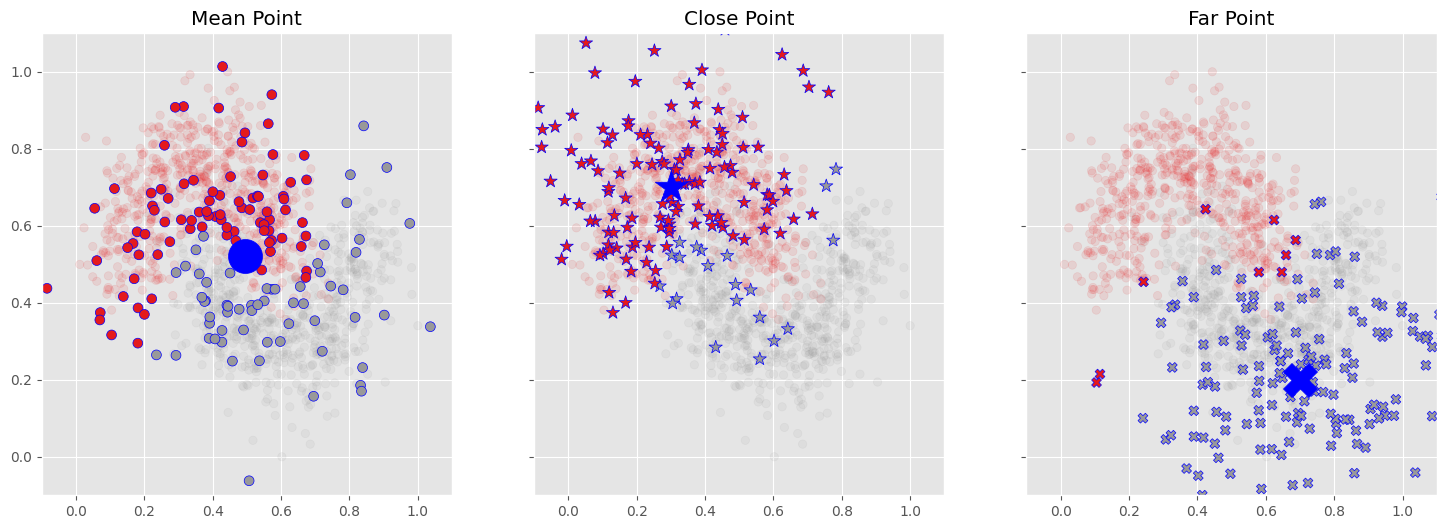

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)


# Scatter the data
axs[0].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[1].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[2].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Mean
axs[0].set_title('Mean Point')
axs[0].scatter(
    moons_normal_sample_mean[:, 0], moons_normal_sample_mean[:, 1],
    marker='o', cmap=plt.cm.Set1, c=moons_normal_sample_mean_crisp,
    edgecolors='b', s=50)
axs[0].scatter(
    moons_mean_point[0], moons_mean_point[1],
    marker='o', c='b', s=600, label='Mean Point')

# Close
axs[1].set_title('Close Point')
axs[1].scatter(
    moons_normal_sample_close[:, 0], moons_normal_sample_close[:, 1],
    marker='*', cmap=plt.cm.Set1, c=moons_normal_sample_close_crisp,
    edgecolors='b', s=100)
axs[1].scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

# Far
axs[2].set_title('Far Point')
axs[2].scatter(
    moons_normal_sample_far[:, 0], moons_normal_sample_far[:, 1],
    marker='X', cmap=plt.cm.Set1, c=moons_normal_sample_far_crisp,
    edgecolors='b', s=50)
axs[2].scatter(
    moons_far_point[0], moons_far_point[1],
    marker='X', c='b', s=600, label='Far Point')

#### Truncated Normal Sampling ####
*Truncated Normal Sampling* is accessible via the
[fatf.data.utils.augmentation.TruncatedNormalSampling](https://fat-forensics.org/generated/fatf.utils.data.augmentation.TruncatedNormalSampling.html)
class.

This sampler is the same as `fatf.data.utils.augmentation.NormalSampling`,
except for the sampled values being truncated at the minimum and maximum of
each feature -- these cut off points are computed based on the data set used
to initialise this class.


In [19]:
moons_truncated_sampler = fatf_augmentation.TruncatedNormalSampling(
    moons_X_test)

Let's see how it works for the *mean* instance.

In [20]:
moons_truncated_sample_mean = moons_truncated_sampler.sample(
        moons_mean_point,
        samples_number=moons_samples_number)

moons_truncated_sample_mean_crisp = clf_moons_crisp.predict(
    moons_truncated_sample_mean)

Now, the *boundary* instance.

In [21]:
moons_truncated_sample_close = moons_truncated_sampler.sample(
    moons_boundary_point,
    samples_number=moons_samples_number)

moons_truncated_sample_close_crisp = clf_moons_crisp.predict(
    moons_truncated_sample_close)

And the *far* instance.

In [22]:
moons_truncated_sample_far = moons_truncated_sampler.sample(
    moons_far_point,
    samples_number=moons_samples_number)

moons_truncated_sample_far_crisp = clf_moons_crisp.predict(
    moons_truncated_sample_far)

Now, let's visualise these three samples side by side.

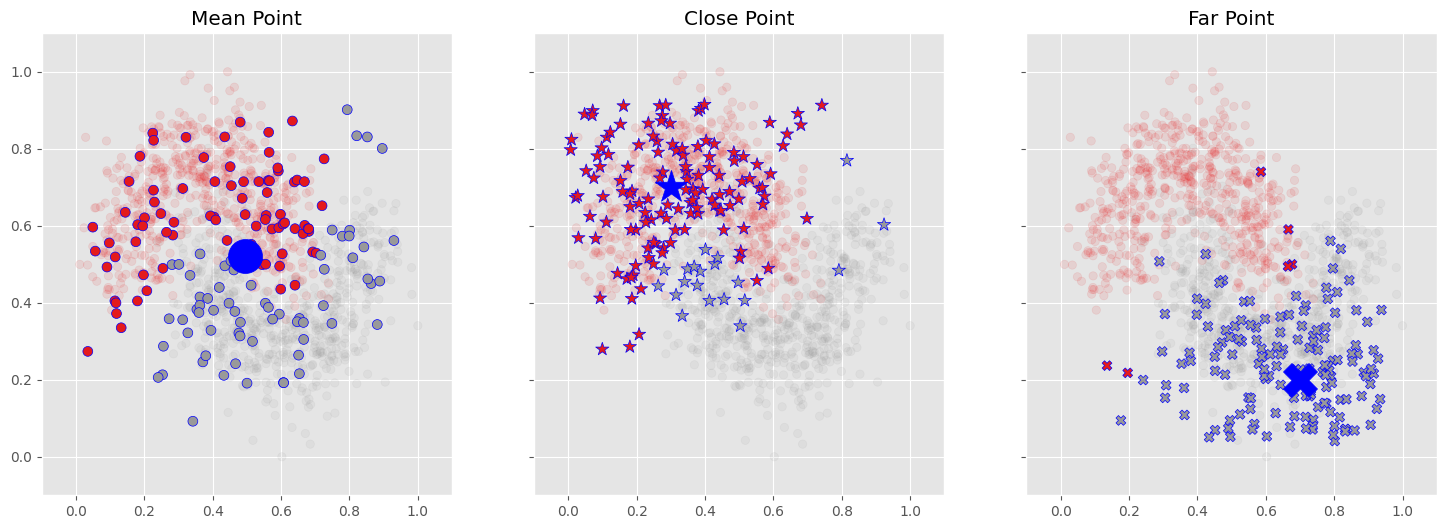

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)


# Scatter the data
axs[0].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[1].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[2].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Mean
axs[0].set_title('Mean Point')
axs[0].scatter(
    moons_truncated_sample_mean[:, 0], moons_truncated_sample_mean[:, 1],
    marker='o', cmap=plt.cm.Set1, c=moons_truncated_sample_mean_crisp,
    edgecolors='b', s=50)
axs[0].scatter(
    moons_mean_point[0], moons_mean_point[1],
    marker='o', c='b', s=600, label='Mean Point')

# Close
axs[1].set_title('Close Point')
axs[1].scatter(
    moons_truncated_sample_close[:, 0], moons_truncated_sample_close[:, 1],
    marker='*', cmap=plt.cm.Set1, c=moons_truncated_sample_close_crisp,
    edgecolors='b', s=100)
axs[1].scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

# Far
axs[2].set_title('Far Point')
axs[2].scatter(
    moons_truncated_sample_far[:, 0], moons_truncated_sample_far[:, 1],
    marker='X', cmap=plt.cm.Set1, c=moons_truncated_sample_far_crisp,
    edgecolors='b', s=50)
axs[2].scatter(
    moons_far_point[0], moons_far_point[1],
    marker='X', c='b', s=600, label='Far Point')

#### Mixup Sampling ####
*Mixup Sampling* is accessible via the
[fatf.data.utils.augmentation.Mixup](https://fat-forensics.org/generated/fatf.utils.data.augmentation.Mixup.html)
class.

For a specific data point, this sampler first selects instances at random from
the data set that was used to initialise the sampler.
Then, it draws (*numeric*) samples from a Beta distribution and uses them to
compose new *data* samples according to the convex combination of these samples
and the instances randomly sampled from the data set.
Given points $x_i$, $x_j$ and their labels $y_i$, $y_j$ drawn at random from the
initialisation data set, and $\lambda$ drawn from a Beta distribution,
a new data point is created as follows:

\begin{align}
\tilde{x} &= \lambda x_i + (1-\lambda)x_j \\
\tilde{y} &= \lambda y_i + (1-\lambda)y_j
\end{align}

In [24]:
moons_mixup_sampler = fatf_augmentation.Mixup(
    moons_X_test, moons_y_test)

Let's see how it works for the *mean* instance.

In [25]:
moons_mixup_sample_mean = moons_mixup_sampler.sample(
        moons_mean_point,
        samples_number=moons_samples_number)

moons_mixup_sample_mean_crisp = clf_moons_crisp.predict(
    moons_mixup_sample_mean)

Now, the *boundary* instance.

In [26]:
moons_mixup_sample_close = moons_mixup_sampler.sample(
    moons_boundary_point,
    samples_number=moons_samples_number)

moons_mixup_sample_close_crisp = clf_moons_crisp.predict(
    moons_mixup_sample_close)

And the *far* instance.

In [27]:
moons_mixup_sample_far = moons_mixup_sampler.sample(
    moons_far_point,
    samples_number=moons_samples_number)

moons_mixup_sample_far_crisp = clf_moons_crisp.predict(
    moons_mixup_sample_far)

Now, let's visualise these three samples side by side.

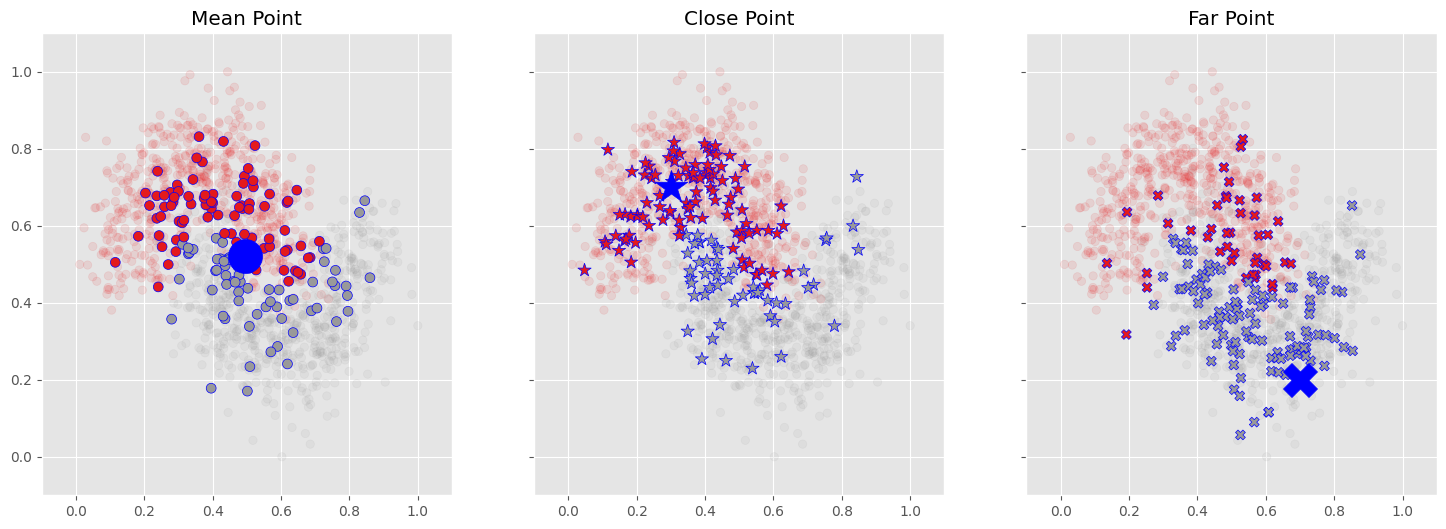

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)


# Scatter the data
axs[0].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[1].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[2].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Mean
axs[0].set_title('Mean Point')
axs[0].scatter(
    moons_mixup_sample_mean[:, 0], moons_mixup_sample_mean[:, 1],
    marker='o', cmap=plt.cm.Set1, c=moons_mixup_sample_mean_crisp,
    edgecolors='b', s=50)
axs[0].scatter(
    moons_mean_point[0], moons_mean_point[1],
    marker='o', c='b', s=600, label='Mean Point')

# Close
axs[1].set_title('Close Point')
axs[1].scatter(
    moons_mixup_sample_close[:, 0], moons_mixup_sample_close[:, 1],
    marker='*', cmap=plt.cm.Set1, c=moons_mixup_sample_close_crisp,
    edgecolors='b', s=100)
axs[1].scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

# Far
axs[2].set_title('Far Point')
axs[2].scatter(
    moons_mixup_sample_far[:, 0], moons_mixup_sample_far[:, 1],
    marker='X', cmap=plt.cm.Set1, c=moons_mixup_sample_far_crisp,
    edgecolors='b', s=50)
axs[2].scatter(
    moons_far_point[0], moons_far_point[1],
    marker='X', c='b', s=600, label='Far Point')

#### Normal Class Discovery ####
Sampling with *Normal Class Discovery* is available via the
[fatf.data.utils.augmentation.NormalClassDiscovery](https://fat-forensics.org/generated/fatf.utils.data.augmentation.NormalClassDiscovery.html)
class.

This sampler ensures that the generated sample has at least a predefined
proportion (`class_proportion_threshold` parameter) of every possible class.
For a specific data point, it samples with a normal distribution centred around
this point, incrementally increasing the standard deviation of the sample until
its class proportion (assigned by the predictive function) satisfies
the user-specified requirement.
Next, one of the data points found to be in another class is used as the centre
of the normal distribution sampling to discover another class.
These steps are repeated until all of the classes (in the predefined
proportion) are present in the sample.

In [29]:
moons_discovery_sampler = fatf_augmentation.NormalClassDiscovery(
    moons_X_test,
    clf_moons_crisp.predict,
    classes_number=2,
    class_proportion_threshold=0.05,
    standard_deviation_init=0.1,
    standard_deviation_increment=0.1)

Let's see how it works for the *mean* instance.

In [30]:
moons_discovery_sample_mean = moons_discovery_sampler.sample(
        moons_mean_point,
        samples_number=moons_samples_number)

moons_discovery_sample_mean_crisp = clf_moons_crisp.predict(
    moons_discovery_sample_mean)

Now, the *boundary* instance.

In [31]:
moons_discovery_sample_close = moons_discovery_sampler.sample(
    moons_boundary_point,
    samples_number=moons_samples_number)

moons_discovery_sample_close_crisp = clf_moons_crisp.predict(
    moons_discovery_sample_close)

And the *far* instance.

In [32]:
moons_discovery_sample_far = moons_discovery_sampler.sample(
    moons_far_point,
    samples_number=moons_samples_number)

moons_discovery_sample_far_crisp = clf_moons_crisp.predict(
    moons_discovery_sample_far)

Now, let's visualise these three samples side by side.

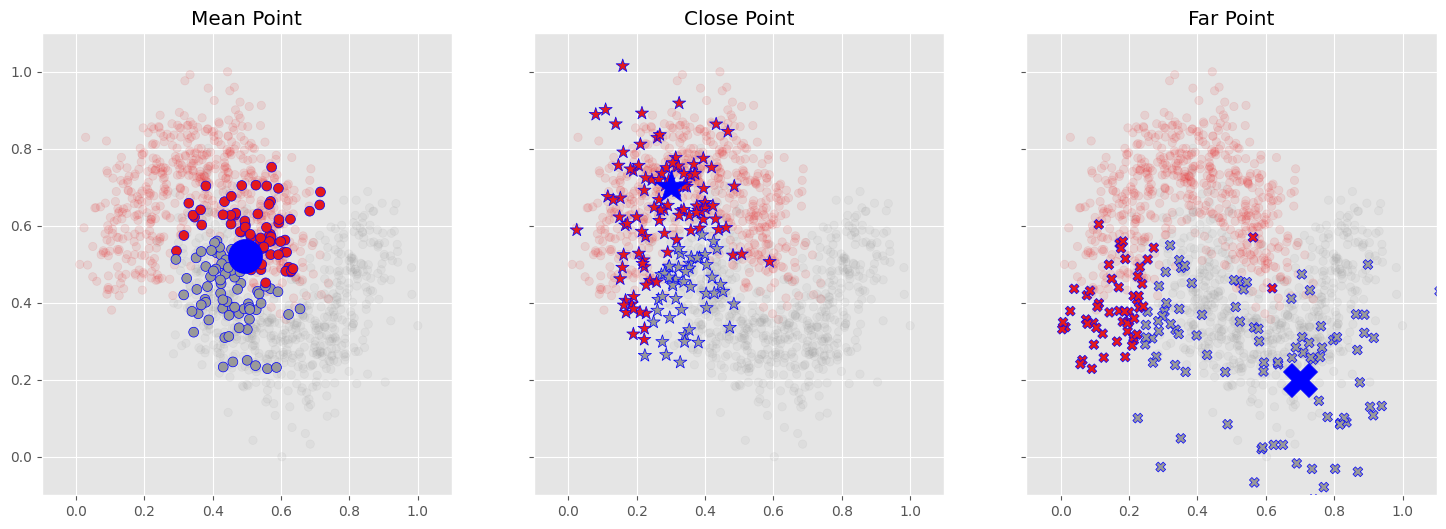

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)


# Scatter the data
axs[0].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[1].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[2].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

# Mean
axs[0].set_title('Mean Point')
axs[0].scatter(
    moons_discovery_sample_mean[:, 0], moons_discovery_sample_mean[:, 1],
    marker='o', cmap=plt.cm.Set1, c=moons_discovery_sample_mean_crisp,
    edgecolors='b', s=50)
axs[0].scatter(
    moons_mean_point[0], moons_mean_point[1],
    marker='o', c='b', s=600, label='Mean Point')

# Close
axs[1].set_title('Close Point')
axs[1].scatter(
    moons_discovery_sample_close[:, 0], moons_discovery_sample_close[:, 1],
    marker='*', cmap=plt.cm.Set1, c=moons_discovery_sample_close_crisp,
    edgecolors='b', s=100)
axs[1].scatter(
    moons_boundary_point[0], moons_boundary_point[1],
    marker='*', c='b', s=600, label='Boundary Point')

# Far
axs[2].set_title('Far Point')
axs[2].scatter(
    moons_discovery_sample_far[:, 0], moons_discovery_sample_far[:, 1],
    marker='X', cmap=plt.cm.Set1, c=moons_discovery_sample_far_crisp,
    edgecolors='b', s=50)
axs[2].scatter(
    moons_far_point[0], moons_far_point[1],
    marker='X', c='b', s=600, label='Far Point')

#### Samplers Comparison ####
To facilitate easier comparison of the samplers, let's plot all of our results
within a single figure.

In [34]:
samplers_names = [
    'Normal',
    'Truncated',
    'Mixup',
    'Discovery'
]

moons_samplers = [
    [(moons_normal_sample_mean, moons_normal_sample_mean_crisp),
     (moons_normal_sample_close, moons_normal_sample_close_crisp),
     (moons_normal_sample_far, moons_normal_sample_far_crisp)],
    [(moons_truncated_sample_mean, moons_truncated_sample_mean_crisp),
     (moons_truncated_sample_close, moons_truncated_sample_close_crisp),
     (moons_truncated_sample_far, moons_truncated_sample_far_crisp)],
    [(moons_mixup_sample_mean, moons_mixup_sample_mean_crisp),
     (moons_mixup_sample_close, moons_mixup_sample_close_crisp),
     (moons_mixup_sample_far, moons_mixup_sample_far_crisp)],
    [(moons_discovery_sample_mean, moons_discovery_sample_mean_crisp),
     (moons_discovery_sample_close, moons_discovery_sample_close_crisp),
     (moons_discovery_sample_far, moons_discovery_sample_far_crisp)]
]

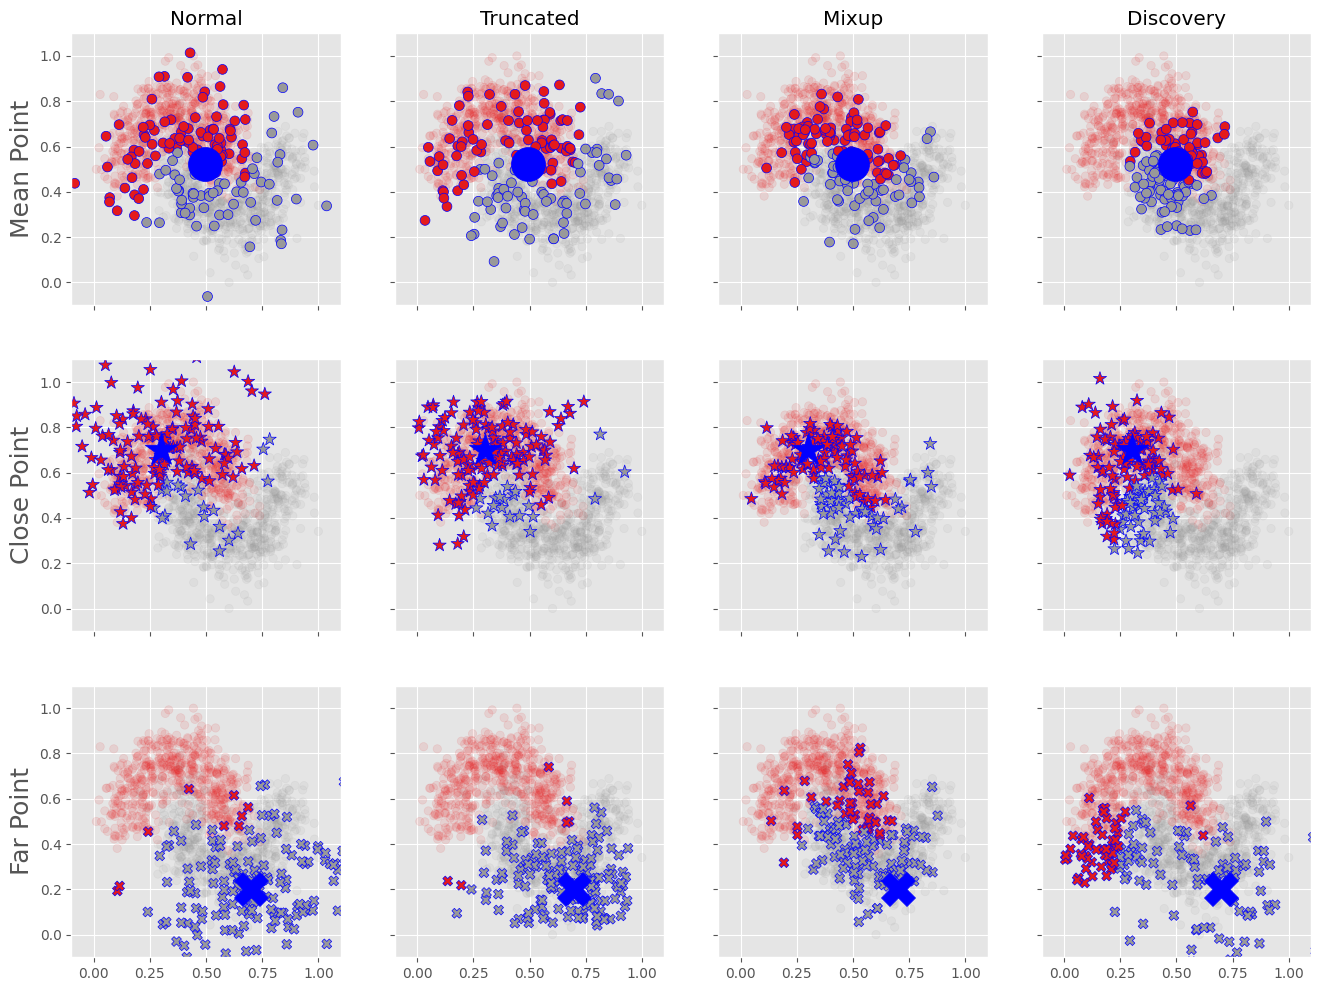

In [35]:
# Plot the different samples for mean, close and far data point with the class
# predicted by the crisp black box.

fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)

axs[0, 0].set_ylabel('Mean Point', fontsize=18)
axs[1, 0].set_ylabel('Close Point', fontsize=18)
axs[2, 0].set_ylabel('Far Point', fontsize=18)

axs[0, 0].set_xlim(-0.1, 1.1)
axs[0, 0].set_ylim(-0.1, 1.1)

for i, name in enumerate(samplers_names):
    # Formatting the subplot
    axs[0, i].set_title(name)

    # Scatter the data
    axs[0, i].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
    axs[1, i].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
    axs[2, i].scatter(
        moons_X[:, 0], moons_X[:, 1],
        cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
    
    # Mean
    means_X, means_y = moons_samplers[i][0]
    axs[0, i].scatter(
        means_X[:, 0], means_X[:, 1],
        marker='o', cmap=plt.cm.Set1, c=means_y,
        edgecolors='b', s=50)

    axs[0, i].scatter(
        moons_mean_point[0], moons_mean_point[1],
        marker='o', c='b', s=600, label='Mean Point')
    
    # Close
    close_X, close_y = moons_samplers[i][1]
    axs[1, i].scatter(
        close_X[:, 0], close_X[:, 1],
        marker='*', cmap=plt.cm.Set1, c=close_y,
        edgecolors='b', s=100)

    axs[1, i].scatter(
        moons_boundary_point[0], moons_boundary_point[1],
        marker='*', c='b', s=600, label='Boundary Point')
    
    # Far
    far_X, far_y = moons_samplers[i][2]
    axs[2, i].scatter(
        far_X[:, 0], far_X[:, 1],
        marker='X', cmap=plt.cm.Set1, c=far_y,
        edgecolors='b', s=50)

    axs[2, i].scatter(
        moons_far_point[0], moons_far_point[1],
        marker='X', c='b', s=600, label='Far Point')

### Measuring Sampling Quality ###
The final plot provides a comprehensive overview of our four sampling
approaches.
Diversity of our sample clearly depends on both:
* the location of the point around which we sample
  (and its nearest black-box decision boundary); and
* the sampling algorithm itself.

Nonetheless, with a high-quality sampling strategy, the location of the
instance plays a smaller role -- see the last two columns of the final plot.
*Mixup* and *Class Discovery* perform better than the *Normal* and
*Truncated Normal* samplers since they have a built-in advantage: they both work
with data labels (either ground truth or black-box predictions).

When sampling data locally to build our surrogate explainer, we should **strive
for diversity of predictions**.
Having a mixture of different classes is a sign of a nearby decision boundary,
which ultimately our surrogate tries to approximate.
With a higher than two number of dimensions, however, we cannot visually
inspect the diversity of our sample.
Instead, we can reuse the strategy from building interpretable representations
(see the *Interpretable Representation* notebook):
* if the model is probabilistic, we can measure *Mean Squared Error* of the
  black-box predictions for our sampled data to understand their diversity; and
* if the black box is *crisp*, we can do the same with *Gini Index*.

In both cases we should strive for the highest possible number: 0.5 for Gini
Index when dealing with **two** classes, and 1.0 for MSE.
Since thus far we were using the crisp black box for our sampling experiments,
we will measure Gini Index of our samples.

In [36]:
bullet_format = '    -> {} <- : {:.3f}'
for i, name in enumerate(samplers_names):
    print('**{}** sampler:'.format(name))

    gini_mean = fatf_ecml.gini_index(moons_samplers[i][0][1])
    print(bullet_format.format('mean instance ', gini_mean))

    gini_close = fatf_ecml.gini_index(moons_samplers[i][1][1])
    print(bullet_format.format('close instance', gini_close))

    gini_far = fatf_ecml.gini_index(moons_samplers[i][2][1])
    print(bullet_format.format('far instance  ', gini_far))

    print('')

**Normal** sampler:
    -> mean instance  <- : 0.480
    -> close instance <- : 0.241
    -> far instance   <- : 0.113

**Truncated** sampler:
    -> mean instance  <- : 0.491
    -> close instance <- : 0.231
    -> far instance   <- : 0.077

**Mixup** sampler:
    -> mean instance  <- : 0.489
    -> close instance <- : 0.453
    -> far instance   <- : 0.403

**Discovery** sampler:
    -> mean instance  <- : 0.500
    -> close instance <- : 0.430
    -> far instance   <- : 0.461



These numbers confirm our visual findings.
Both *Mixup* and *Class Discovery* do a good job in finding a diverse
sample regardless of the sampling location.

### Sampling from Interpretable Representations ###
The sampling procedure depends on the type of explained data.
For *images* and *text*, sampling **must** be performed in the
**binary interpretable representation** since doing it in the original
data domain is an ill-defined procedure (see the tutorial slides for more
details).
For *tabular data*, however, sampling can be done in **either** a binary
interpretable representation or the original data domain
(our experiments so far).

While there are many benefits of sampling in the original domain of tabular
data (such as controlling for locality and ensuring sample diversity),
some surrogate explainers (e.g., LIME) choose to sample in an interpretable
representation regardless of the data type.
While this procedure would be quite convoluted with a tree-based
interpretable representation -- or even impossible given that the most
promising strategy is training the tree on a local sample --
it is just about feasible for the quartile-based interpretable representation.

In the popular LIME algorithm, for example, sampling is performed in the
*discretised* space of the quartile-based interpretable representation
and then transformed into:
* the **binary representation** for fitting a local surrogate model; and
* the **original data domain** to predict the sample with a black box.

While sampling directly in the binary domain is possible, doing so would add
*randomness* to the sample since going from the binary back into the
discrete domain requires choosing a hyper-rectangle at random
for any binary component that is 0
(see the *Interpretable Representation* notebook and the tutorial slides for reference).
Sampling from the *discrete* space instead does not fully
eradicate randomness since such a transformation is inherently **stochastic** --
there is one-to-many mapping between the discrete and the original data
domains.
As such, to perform this transformation one must randomly sample values
from each hyper-rectangle according to the distribution of training samples
located therein.
This step makes the explanation generator stochastic, which can be easily
avoided by sampling tabular data in their original domain.

---

Let's investigate the effect of sampling from a discretisation generated with
a quartile-based interpretable representation for our toy data set.

We start by building the *Quartile Discretiser* for our data set.

In [37]:
moons_discretiser = fatf_discretisation.QuartileDiscretiser(
    moons_X_test)

Now, let's sample 150 data points in this discrete space
(its values are between 0 and 3)
and identify their unique hyper-rectangles according to our
quartile-based discretisation.

In [38]:
moons_discrete_sample = np.random.randint(
    0, high=4,
    size=(150, moons_discretiser.features_number),
    dtype=np.int8)

# Get hyper-rectangle assignment
moons_discrete_sample_qid = np.zeros(
    moons_discrete_sample.shape[0], dtype=np.int8)
unique_rows = np.unique(moons_discrete_sample, axis=0)
for i, row in enumerate(unique_rows):
    mask = (moons_discrete_sample == row).all(axis=1)
    moons_discrete_sample_qid[mask] = i

To better understand the randomness caused by the *undiscretisation* step,
we will undiscretise our sample twice.

In [39]:
undiscretised_dataset_1 = fatf_ecml.undiscretise_data(
    moons_discrete_sample, moons_discretiser, moons_X_test)

undiscretised_dataset_2 = fatf_ecml.undiscretise_data(
    moons_discrete_sample, moons_discretiser, moons_X_test)

Next, let's visualise the results.

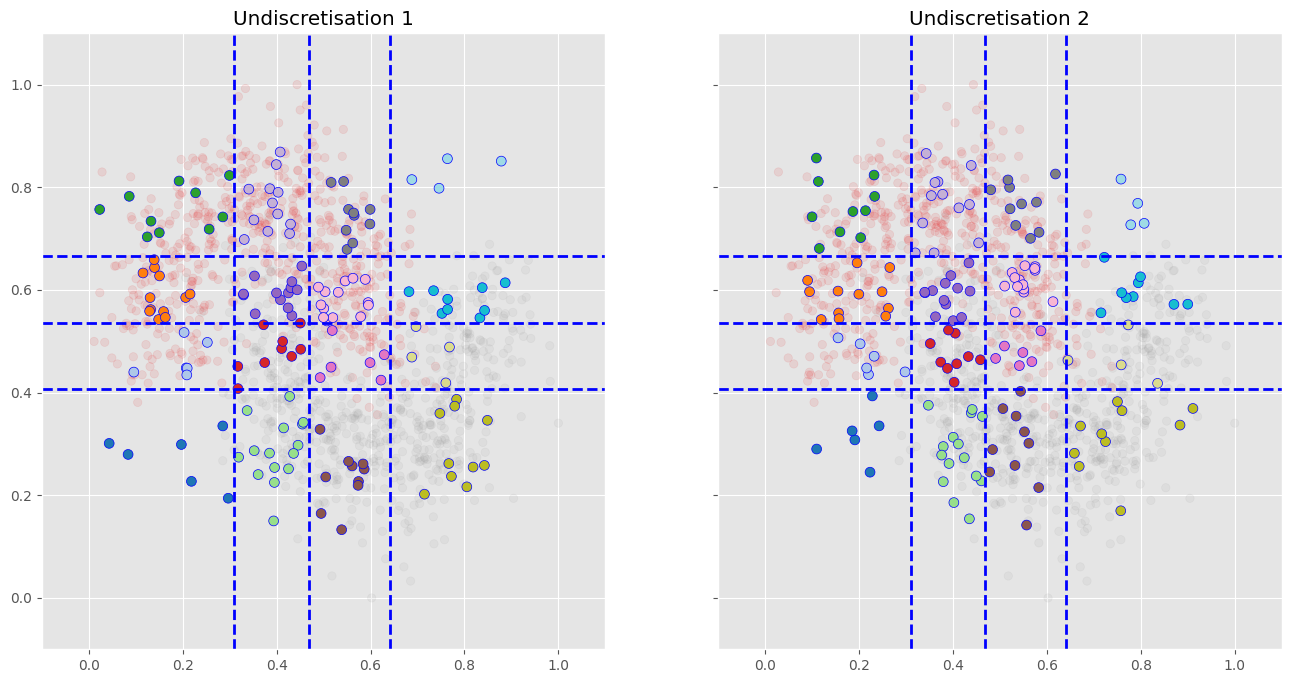

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, 1.1)

axs[0].set_title('Undiscretisation 1')
axs[1].set_title('Undiscretisation 2')

axs[0].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)
axs[1].scatter(
    moons_X[:, 0], moons_X[:, 1],
    cmap=plt.cm.Set1, c=moons_y, alpha=0.1)

axs[0].scatter(
    undiscretised_dataset_1[:, 0],
    undiscretised_dataset_1[:, 1],
    cmap=plt.cm.tab20,
    c=moons_discrete_sample_qid,
    edgecolors='b', s=50)

axs[1].scatter(
    undiscretised_dataset_2[:, 0],
    undiscretised_dataset_2[:, 1],
    cmap=plt.cm.tab20,
    c=moons_discrete_sample_qid,
    edgecolors='b', s=50)

# Draw quartile lines to show the hyper-rectangles
quartile_boundaries_x = moons_discretiser.feature_bin_boundaries.get(0)
for i in quartile_boundaries_x:
    axs[0].plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')
    axs[1].plot([i, i], [-0.1, 1.1], linewidth=2, linestyle='--', c='blue')
quartile_boundaries_y = moons_discretiser.feature_bin_boundaries.get(1)
for i in quartile_boundaries_y:
    axs[0].plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')
    axs[1].plot([-0.1, 1.1], [i, i], linewidth=2, linestyle='--', c='blue')

Clearly, the randomness of the *undiscretisation* step can be detrimental to reproducibility of surrogate explanations.
Nonetheless, this procedure is worth understanding to appreciate the simplicity
and level of control (over the sample characteristics) brought by performing
this procedure in the original domain of tabular data.

While in the case of the *Two Moons* data set the sampling results may not seem
too unreasonable, recall the overwhelming *number* of hyper-rectangles ($4^d$ where $d$
is the number of features) and their *sparsity* for real-life data --
see the *Interpretable Representation* notebook for more details.
All in all, sampling from the original data domain may provide a better
opportunity to capture the local decision boundary.

## Real-life Data -- Bikes Sharing ##
Now, let's repeat the same experiments for the bikes data set.
We will use *Normal*, *Truncated Normal*, *Mixup* and *Class Discovery*
samplers with three instances:
* the *mean* point of the data set;
* a point close to a black-box decision boundary, i.e., as close as
  possible to 0.3 probability for all three classes; and
* a point far from a black-box decision boundary.

We will then investigate the diversity of the resulting sample by
analysing the proportion of each class as well as measuring their
purity scores.

### Loading Data and Black Boxes ###
We start by loading the *Bikes Sharing* data set and
fitting two black boxes: one probabilistic and one crisp.

In [41]:
(bikes_train_X,
 bikes_test_X,
 bikes_train_y,
 bikes_test_y,
 bikes_feature_names,
 bikes_target_name) = fatf_ecml.generate_bikes(random_seed=42)

bikes_target_classes = ['low', 'medium', 'high']

22-Sep-08 12:50:10 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:50:10 fatf         INFO     Seeding RNGs with 42.


In [42]:
clf_bikes_proba = fatf_ecml.get_random_forest(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Sep-08 12:50:12 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:50:12 fatf         INFO     Seeding RNGs with 42.


In [43]:
clf_bikes_crisp = fatf_ecml.get_svc(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Sep-08 12:50:13 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:50:13 fatf         INFO     Seeding RNGs with 42.


### Choosing Instances ###
Now, we choose three instances to sample around.

In [44]:
bikes_test_pred_proba = clf_bikes_proba.predict_proba(bikes_test_X)

# Mean Point
bikes_mean_point = np.mean(bikes_test_X, axis=0)

bikes_mean_point_pred_proba = clf_bikes_proba.predict_proba(
    [bikes_mean_point])[0, :]
print('Mean Point Prediction: {}.\n'.format(bikes_mean_point_pred_proba))

# Far Point
far_predict = bikes_test_pred_proba.max(axis=1)
far_index = np.argmax(far_predict)

bikes_far_point = bikes_test_X[far_index, :]

print('Far Point Prediction: {}.\n'.format(bikes_test_pred_proba[far_index, :]))

# Close Point
close_pred = np.square(bikes_test_pred_proba - (1 / 3)).sum(axis=1)
close_index = np.argmin(close_pred)

bikes_close_point = bikes_test_X[close_index, :]

print('Close Point Prediction: {}.'.format(
    bikes_test_pred_proba[close_index, :]))

Mean Point Prediction: [0.02451389 0.12835648 0.84712963].

Far Point Prediction: [1. 0. 0.].

Close Point Prediction: [0.2        0.45097643 0.34902357].


### Testing Samplers ###
Instead of testing the samplers one by one, let's analyse all of them at once,
akin to the side-by-side comparison of the samplers for the *Two Moons*
data set.

---

We start by defining the samplers.

In [45]:
samplers_names = [
    'Normal',
    'Truncated',
    'Mixup',
    'Discovery'
]

bikes_samplers = [
    fatf_augmentation.NormalSampling(bikes_test_X),
    fatf_augmentation.TruncatedNormalSampling(bikes_test_X),
    fatf_augmentation.Mixup(
        bikes_test_X,
        bikes_test_y),
    fatf_augmentation.NormalClassDiscovery(
        bikes_test_X,
        clf_bikes_crisp.predict,
        classes_number=3,
        class_proportion_threshold=0.1,
        standard_deviation_init=0.5,
        standard_deviation_increment=1.0)
]

Next, we generate 1500 samples around our three instances.

> **Note:**&nbsp;&nbsp;&nbsp;&nbsp;
  The *Normal Class Discovery* algorithm is sensitive to parameterisation.
  It may throw a `RuntimeError` if it fails to discover the user-defined
  proportion of classes (the `class_proportion_threshold` parameter in the class above).
  In this case, you should tune the `standard_deviation_init` and
  `standard_deviation_increment` parameters to reflect the distribution of
  features in your data.
  Another approach is to increase the number of iterations when calling the
  `sample` method using its `max_iter` parameter (see below).

In [46]:
fatf.setup_random_seed(42)

bikes_samples_number = 1500

bikes_mean_sample = []
bikes_mean_sample_pred = []
bikes_close_sample = []
bikes_close_sample_pred = []
bikes_far_sample = []
bikes_far_sample_pred= []

for sampler_name, sampler in zip(samplers_names, bikes_samplers):
    if sampler_name == 'Discovery':
        kwargs = {'max_iter': 2500}
    else:
        kwargs = dict()

    # Mean Point
    sample = sampler.sample(
        bikes_mean_point,
        samples_number=bikes_samples_number,
        **kwargs)
    bikes_mean_sample.append(sample)

    sample_pred = clf_bikes_crisp.predict(sample)
    bikes_mean_sample_pred.append(sample_pred)
    
    # Close Point
    sample = sampler.sample(
        bikes_close_point,
        samples_number=bikes_samples_number,
        **kwargs)
    bikes_close_sample.append(sample)

    sample_pred = clf_bikes_crisp.predict(sample)
    bikes_close_sample_pred.append(sample_pred)
    
    # Far Point
    sample = sampler.sample(
        bikes_far_point,
        samples_number=bikes_samples_number,
        **kwargs)
    bikes_far_sample.append(sample)

    sample_pred = clf_bikes_crisp.predict(sample)
    bikes_far_sample_pred.append(sample_pred)

22-Sep-08 12:50:15 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:50:15 fatf         INFO     Seeding RNGs with 42.


Now, let's visualise the class counts and compute *Gini Impurity* of each
sample.

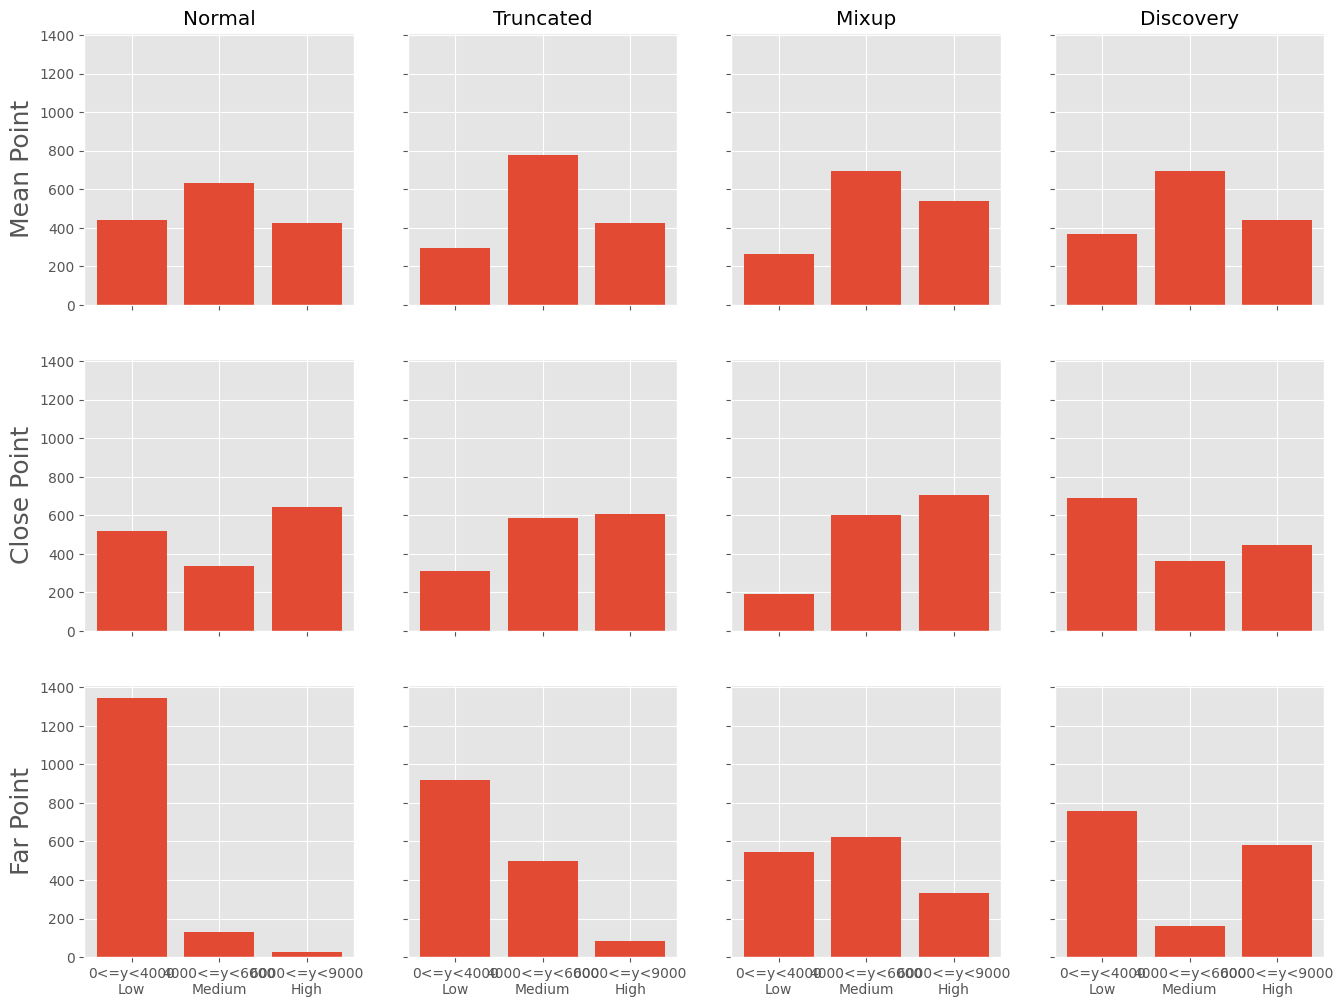

In [47]:
# The bins used for the bikes dataset
bins = [0, 4000, 6000, 9000]
bin_names = [
    '{:.0f}<=y<{:.0f}\nLow'.format(bins[0], bins[1]),
    '{:.0f}<=y<{:.0f}\nMedium'.format(bins[1], bins[2]),
    '{:.0f}<=y<{:.0f}\nHigh'.format(bins[2], bins[3])
]

fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)

axs[0, 0].set_ylabel('Mean Point', fontsize=18)
axs[1, 0].set_ylabel('Close Point', fontsize=18)
axs[2, 0].set_ylabel('Far Point', fontsize=18)

for i, name in enumerate(samplers_names):
    # Formatting the subplot
    axs[0, i].set_title(name)
    
    # Mean Point
    mean_predictions = bikes_mean_sample_pred[i]
    _, mean_counts = np.unique(mean_predictions, return_counts=True)
    axs[0, i].bar(bin_names, mean_counts)
    
    # Close Point
    close_predictions = bikes_close_sample_pred[i]
    _, close_counts = np.unique(close_predictions, return_counts=True)
    axs[1, i].bar(bin_names, close_counts)

    # Far Point
    far_predictions = bikes_far_sample_pred[i]
    _, far_counts = np.unique(far_predictions, return_counts=True)
    axs[2, i].bar(bin_names, far_counts)

(With *three* classes, the maximum impurity is $\frac{2}{3}$.)

In [48]:
bullet_format = '    -> {} <- : {:.3f}'
for i, name in enumerate(samplers_names):
    print('**{}** sampler:'.format(name))

    gini_mean = fatf_ecml.gini_index(bikes_mean_sample_pred[i])
    print(bullet_format.format('mean instance ', gini_mean))

    gini_close = fatf_ecml.gini_index(bikes_close_sample_pred[i])
    print(bullet_format.format('close instance', gini_close))

    gini_far = fatf_ecml.gini_index(bikes_far_sample_pred[i])
    print(bullet_format.format('far instance  ', gini_far))

    print('')

**Normal** sampler:
    -> mean instance  <- : 0.655
    -> close instance <- : 0.646
    -> far instance   <- : 0.190

**Truncated** sampler:
    -> mean instance  <- : 0.611
    -> close instance <- : 0.643
    -> far instance   <- : 0.511

**Mixup** sampler:
    -> mean instance  <- : 0.625
    -> close instance <- : 0.601
    -> far instance   <- : 0.647

**Discovery** sampler:
    -> mean instance  <- : 0.640
    -> close instance <- : 0.641
    -> far instance   <- : 0.583



These numbers reflect our findings from the frequency plots.

## Summary ##
Throughout this notebook we relied on *Gini Impurity* and *crisp* classifiers.
Nonetheless, a similar strategy for finding a useful data sample can be taken
when dealing with *probabilistic* models -- we need to replacing *Gini Impurity*
with *Mean Squared Error*.

---

Now, let's move on to the *Explanation Generation* notebook and use our
knowledge of building faithful interpretable representations and sampling
diverse data points to build a surrogate explainer. 